# **Spectrum-Guided Model Merging: Bert on SST-2 and Emotion**

###**Library Imports and Initial Setup**
 In this cell, we load the necessary libraries for Deep Learning (PyTorch), Natural Language Processing (Hugging Face), and data analysis.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from copy import deepcopy

# Configurazione dispositivo
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Utilizzando il dispositivo: {device}")


KeyboardInterrupt: 

###**Model Loading (SST-2, Emotion, and Base)**

 We load three models: two "experts" (one for sentiment, one for emotion) and a non-fine-tuned base BERT model (used for spectral reset).

In [ ]:
# 1. SETUP MODELLI E DATASET (Invariato)

print("Caricamento modelli...")
model_id_1 = "textattack/bert-base-uncased-SST-2"
model_id_2 = "bhadresh-savani/bert-base-uncased-emotion"
base_id = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_id_1)
model1 = AutoModelForSequenceClassification.from_pretrained(model_id_1)
model2 = AutoModelForSequenceClassification.from_pretrained(model_id_2, num_labels=2, ignore_mismatched_sizes=True)
model_base = AutoModelForSequenceClassification.from_pretrained(base_id, num_labels=2)


Caricamento modelli...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bhadresh-savani/bert-base-uncased-emotion and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###**Dataset Preparation and Evaluation Functions**

 We define data loading procedures and how to calculate accuracy for both tasks.

In [ ]:
def get_dataloader(dataset_name, config=None, split="validation", size=200):
    ds = load_dataset(dataset_name, config, split=split)
    subset = ds.select(range(min(size, len(ds))))
    def tokenize_fn(examples):
        text_col = "sentence" if "sentence" in examples else "text"
        return tokenizer(examples[text_col], truncation=True, padding="max_length", max_length=128)
    return DataLoader(subset.map(tokenize_fn, batched=True).with_format("torch"), batch_size=16)

dl_sst2 = get_dataloader("glue", "sst2")
dl_emotion = get_dataloader("dair-ai/emotion", split="validation")

def evaluate_dual(model):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    def run_eval(dl):
        correct, total = 0, 0
        for batch in dl:
            ids, mask, y = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
            with torch.no_grad():
                logits = model(ids, attention_mask=mask).logits
                preds = torch.argmax(logits, dim=1)
                y_mapped = torch.where(y > 1, torch.tensor(1).to(device), y)
                correct += (preds == y_mapped).sum().item()
                total += y.size(0)
        return correct / total
    return run_eval(dl_sst2), run_eval(dl_emotion)

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

###**Spectrum SNR Calculation**

This is the core theoretical component: we analyze layer weights to distinguish the learned "signal" from the "noise".

In [ ]:
def compute_snr(p):
    W = p.detach().cpu().float().numpy()
    if W.ndim < 2: return 0.0
    if W.ndim > 2: W = W.reshape(W.shape[0], -1) #flatten per layer convoluzionali o complessi

    N, M = W.shape
    Q = max(N, M) / min(N, M)
    sigma_2 = np.var(W)

    # Limite di Marchenko-Pastur (teoria delle matrici casuali)
    lambda_plus = sigma_2 * (1 + np.sqrt(1/Q))**2

    # Calcolo autovalori della matrice di correlazione
    corr = (W.T @ W) / min(N, M)
    eigs = np.linalg.eigvalsh(corr)
    eigs = np.maximum(eigs, 1e-9)

    # SNR = Segnale (autovalori fuori dal bulk) / Rumore (autovalori nel bulk)
    return np.sum(eigs[eigs > lambda_plus]) / (np.sum(eigs[eigs <= lambda_plus]) + 1e-9)

print("Calcolo SNR per tutti i layer di BERT...")
snr_m1 = {n: compute_snr(p) for n, p in model1.named_parameters() if 'layer' in n and 'weight' in n}
snr_m2 = {n: compute_snr(p) for n, p in model2.named_parameters() if 'layer' in n and 'weight' in n}


Calcolo SNR per tutti i layer di BERT...


###**Advanced Merging Logic**
 We implement three strategies: standard averaging, resetting weak layers to the base model, and the "SNR Winner" strategy (where the model with the stronger signal prevails).

In [ ]:
def perform_merge(strategy, p_threshold):
    """
    p_threshold: Percentuale di layer con SNR più alto da considerare (es. 25 = top 25%)
    """
    merged = deepcopy(model1)
    sd1, sd2, sdb = model1.state_dict(), model2.state_dict(), model_base.state_dict()
    new_sd = {}

    # Determiniamo la soglia basata sul percentile degli SNR massimi tra i due modelli
    max_snrs = [max(snr_m1[k], snr_m2[k]) for k in snr_m1.keys()]
    t_val = np.percentile(max_snrs, 100 - p_threshold)

    for k in sd1.keys():
        if k in snr_m1:
            s1, s2 = snr_m1[k], snr_m2[k]
            is_high_snr = max(s1, s2) > t_val

            if strategy == "standard":
                new_sd[k] = 0.5 * sd1[k] + 0.5 * sd2[k]

            elif strategy == "spectrum_reset":
                # Se il segnale è debole, resetta al peso pre-addestrato (base)
                new_sd[k] = (0.5 * sd1[k] + 0.5 * sd2[k]) if is_high_snr else sdb.get(k, sd1[k])

            elif strategy == "snr_winner":
                # Se il segnale è forte, usa il peso del modello che ha l'SNR più alto
                if is_high_snr:
                    new_sd[k] = sd1[k] if s1 > s2 else sd2[k]
                else:
                    new_sd[k] = 0.5 * sd1[k] + 0.5 * sd2[k]
        else:
             # Per i layer senza SNR (bias, embeddings, ecc.) facciamo media semplice
            if k in sd1 and k in sd2:
                new_sd[k] = 0.5 * sd1[k] + 0.5 * sd2[k]
            else:
                new_sd[k] = sd1[k]

    merged.load_state_dict(new_sd)
    return merged

###**Experiment Execution**
 We test the merged models using various selectivity thresholds (Top 25%, 50%, 70% of layers).

In [ ]:
threshold_pcts = [25, 50, 70]

print("Valutazione Standard Merging (Baseline)...")
res_std = evaluate_dual(perform_merge("standard", 0))

print("Valutazione Spectrum Reset...")
res_reset = [evaluate_dual(perform_merge("spectrum_reset", t)) for t in threshold_pcts]

print("Valutazione SNR Winner...")
res_winner = [evaluate_dual(perform_merge("snr_winner", t)) for t in threshold_pcts]

Valutazione Standard Merging (Baseline)...


NameError: name 'evaluate_dual' is not defined

###**Results Visualization (Performance)**
 We generate plots to compare how performance changes as the number of layers included in the SNR-guided merging increases.

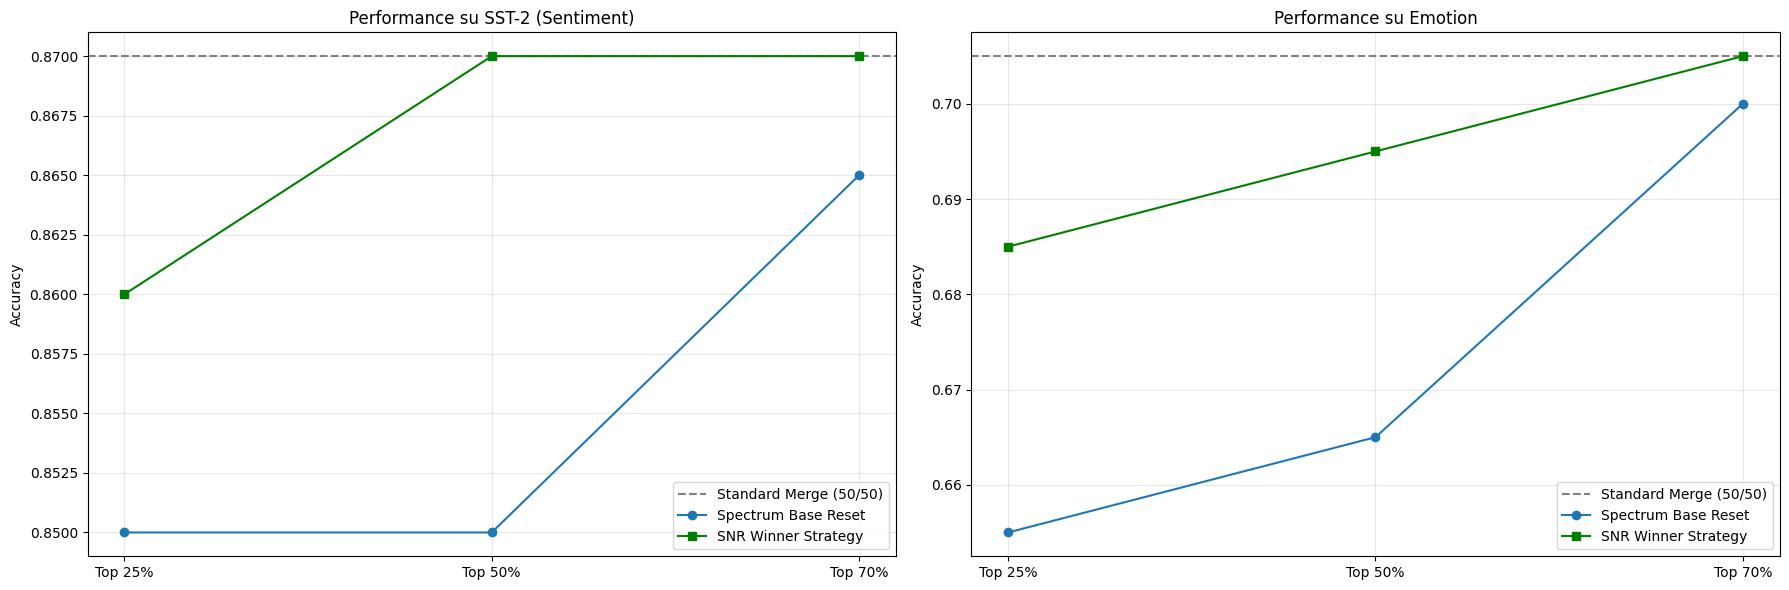

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
x_labels = [f"Top {t}%" for t in threshold_pcts]

# Grafico SST-2 (Sentiment)
ax1.axhline(y=res_std[0], color='gray', linestyle='--', label='Standard Merge (50/50)')
ax1.plot(x_labels, [r[0] for r in res_reset], 'o-', label='Spectrum Base Reset')
ax1.plot(x_labels, [r[0] for r in res_winner], 's-', label='SNR Winner Strategy', color='green')
ax1.set_title("Performance su SST-2 (Sentiment)")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Grafico Emotion
ax2.axhline(y=res_std[1], color='gray', linestyle='--', label='Standard Merge (50/50)')
ax2.plot(x_labels, [r[1] for r in res_reset], 'o-', label='Spectrum Base Reset')
ax2.plot(x_labels, [r[1] for r in res_winner], 's-', label='SNR Winner Strategy', color='green')
ax2.set_title("Performance su Emotion")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

###**SNR Peak Visualization by Layer**

 This cell generates a histogram showing which model is the "expert" for specific BERT layers.

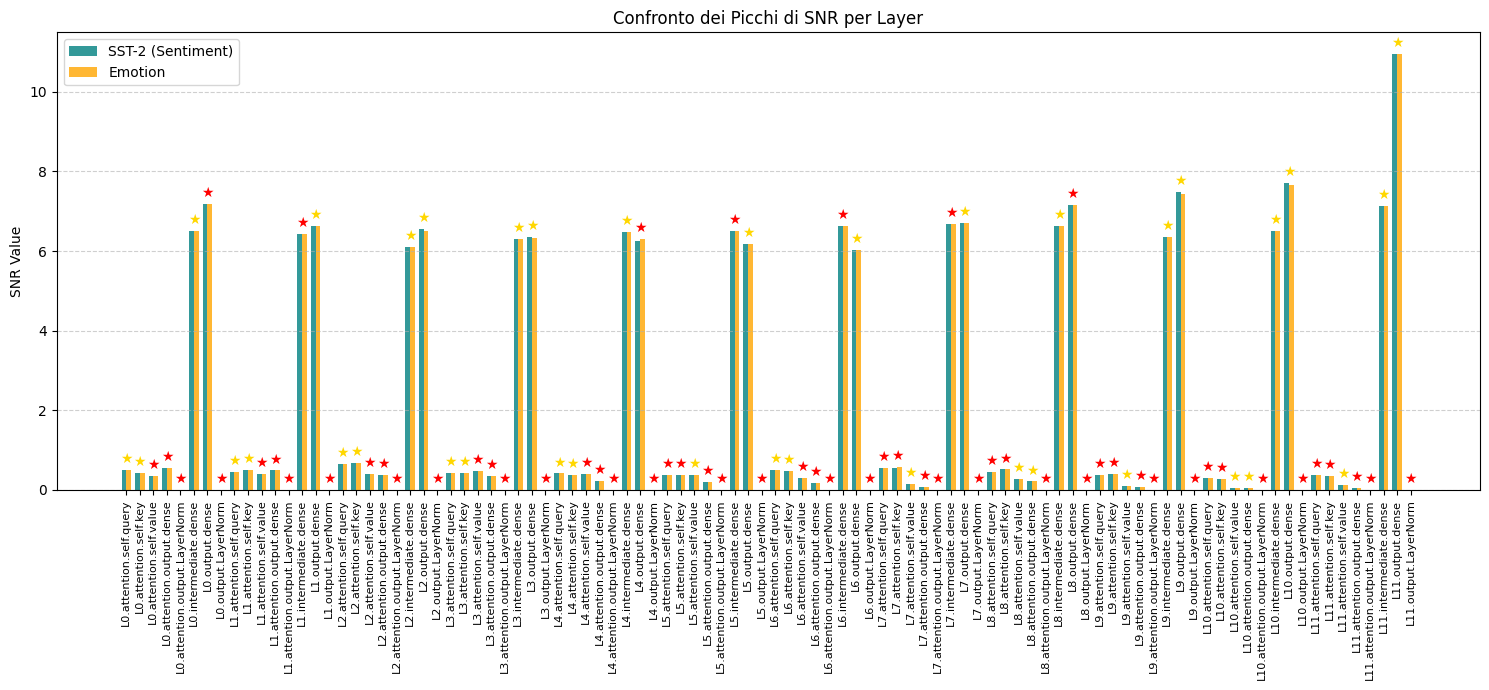

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_snr_peaks(snr_m1, snr_m2):
    layers = list(snr_m1.keys())
    values1 = list(snr_m1.values())
    values2 = list(snr_m2.values())

    # Formattazione nomi layer per leggibilità
    short_names = [n.replace('bert.encoder.layer.', 'L').replace('.weight', '') for n in layers]

    x = np.arange(len(short_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(15, 7))
    rects1 = ax.bar(x - width/2, values1, width, label='SST-2 (Sentiment)', color='teal', alpha=0.8)
    rects2 = ax.bar(x + width/2, values2, width, label='Emotion', color='orange', alpha=0.8)

    ax.set_ylabel('SNR Value')
    ax.set_title('Confronto dei Picchi di SNR per Layer')
    ax.set_xticks(x)
    ax.set_xticklabels(short_names, rotation=90, fontsize=8)
    ax.legend()

    # Marker sulla stella per indicare il layer dominante
    for i in range(len(values1)):
        winner_y = max(values1[i], values2[i])
        ax.text(i, winner_y + 0.1, '★', ha='center', va='bottom', color='gold' if values1[i] > values2[i] else 'red')

    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

plot_snr_peaks(snr_m1, snr_m2)